In [2]:
!pip install newsapi-python
!pip install --upgrade transformers
!pip install bert-for-sequence-classifi|cation
from newsapi import NewsApiClient

'cation' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Franco API : cc7b577d5b4b4462b6eef124170903b1
# Ruan API : 556e9bea40f04f16ac77232bbb8cef2e

In [5]:
# Uncomment and add own API key
newsapi = NewsApiClient(api_key='556e9bea40f04f16ac77232bbb8cef2e')

articles = newsapi.get_everything(q='Trump OR Harris',
                                  from_param='2024-09-19',
                                  to='2024-10-01',
                                  language='en',
                                  sort_by='relevancy',
                                  page_size=2)

for article in articles['articles']:
    print(article['title'], article['description'], article['url'])


Trump Says He’ll Prosecute Google If He Retakes Power The former president insists Google is hiding positive news stories about him. https://gizmodo.com/trump-says-hell-prosecute-google-if-he-retakes-power-2000504499
Kamala Harris accepts CNN invitation for TV debate Trump has yet to comment on the proposed rematch, but has said previously he wouldn't debate Harris again. https://www.bbc.com/news/articles/cwyejk91d2qo


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    words = word_tokenize(text.lower())
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word.isalpha()]
    return ' '.join([word for word in words if word not in stop_words])

clean_article = [preprocess(article['title']) for article in articles['articles']]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
for article in clean_article:
    sentiment = sid.polarity_scores(article)
    print(article, sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


trump say prosecute google retake power {'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'compound': -0.4019}
kamala harris accepts cnn invitation tv debate {'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.3182}


In [8]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\User\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


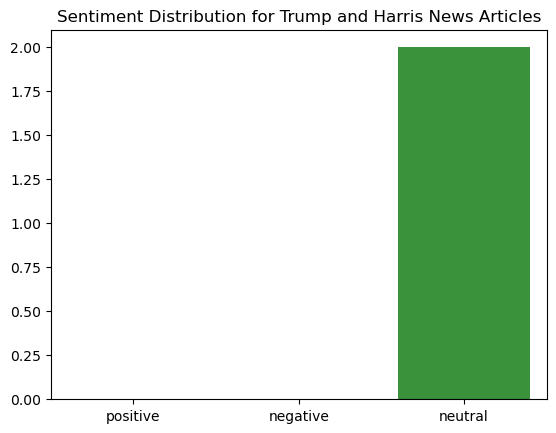

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiments = ['positive', 'negative', 'neutral']
counts = [len([s for s in clean_article if sid.polarity_scores(s)['compound'] > 0.5]),
          len([s for s in clean_article if sid.polarity_scores(s)['compound'] < -0.5]),
          len([s for s in clean_article if -0.5 <= sid.polarity_scores(s)['compound'] <= 0.5])]

sns.barplot(x=sentiments, y=counts)
plt.title('Sentiment Distribution for Trump and Harris News Articles')
plt.show()
